In [1]:
from neuralforecast.losses.pytorch import GMM, MQLoss, DistributionLoss, MAE
from neuralforecast.core import NeuralForecast
from utilsforecast.plotting import plot_series
from neuralforecast.models import DeepAR,TSMixerx, TiDE, MLP, TFT, RNN, TCN, MLPMultivariate, NBEATSx, DeepNPTS, NHITS, BiTCN,LSTM, DilatedRNN, KAN, GRU
from neuralforecast.tsdataset  import TimeSeriesDataset
import pandas as pd
import numpy as np
import logging

In [2]:
df = pd.read_csv('01_FEATURES_PRIME.csv')
df['DT_FECHA'] = pd.to_datetime(df['DT_FECHA'])
df = df.drop(['CO_TIPO_FECHA', 'CO_TIPO_METODO_ENVIO','IS_PRIMERITI','DS_DIVISION_AUM'], axis=1)

df = df.rename(columns={
    'DT_FECHA': 'ds',
    'CO_DIVISION_AUM': 'unique_id',
    'QT_UNIDADES': 'y'
})

exogenous_vars = [
    'PC_DESCUENTO_A_PUBLICAR', 'PC_DESCUENTO_APLICADO', 'VL_POTENCIAL_ESTIMADO', 
    'VL_FORECAST', 'QT_REFS_ESTIMADAS', 'QT_REFS_NUEVAS_ESTIMADAS', 
    'QT_UDS_STOCK_ESTIMADO', 'RATIO_FORE_POTE', 'INTENSIDAD', 'STOCK_DESCUENTO',
    'REFS_DESCUENTO', 'RATIO_STOCK_REFS', 'QT_FORE_DIARIO', 'VL_FORE_DIARIO',
    'STOCK_RELATIVO', 'NRO_ACCIONES', 'QT_FORECAST_desc'
]

df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year
df['day'] = df['ds'].dt.day
df['day_of_week'] = df['ds'].dt.day_of_week
df['day_of_year'] = df['ds'].dt.day_of_year

# exogenous_vars += ['month', 'year','day', 'day_of_week' , 'day_of_year']
exogenous_vars += ['month','day_of_week']

df = df[['unique_id', 'ds', 'y'] + exogenous_vars]
df = df.sort_values(by=['unique_id','ds'])
df = df[df['unique_id'] != 'PRIME_NOCAT']

dummies = pd.get_dummies(df['unique_id'], prefix='CAT')

df_with_dummies = pd.concat([df[['unique_id']], dummies], axis=1)

static_df  = df_with_dummies.groupby('unique_id').max().reset_index()

stat_exog_list = static_df.columns[1:].to_list()

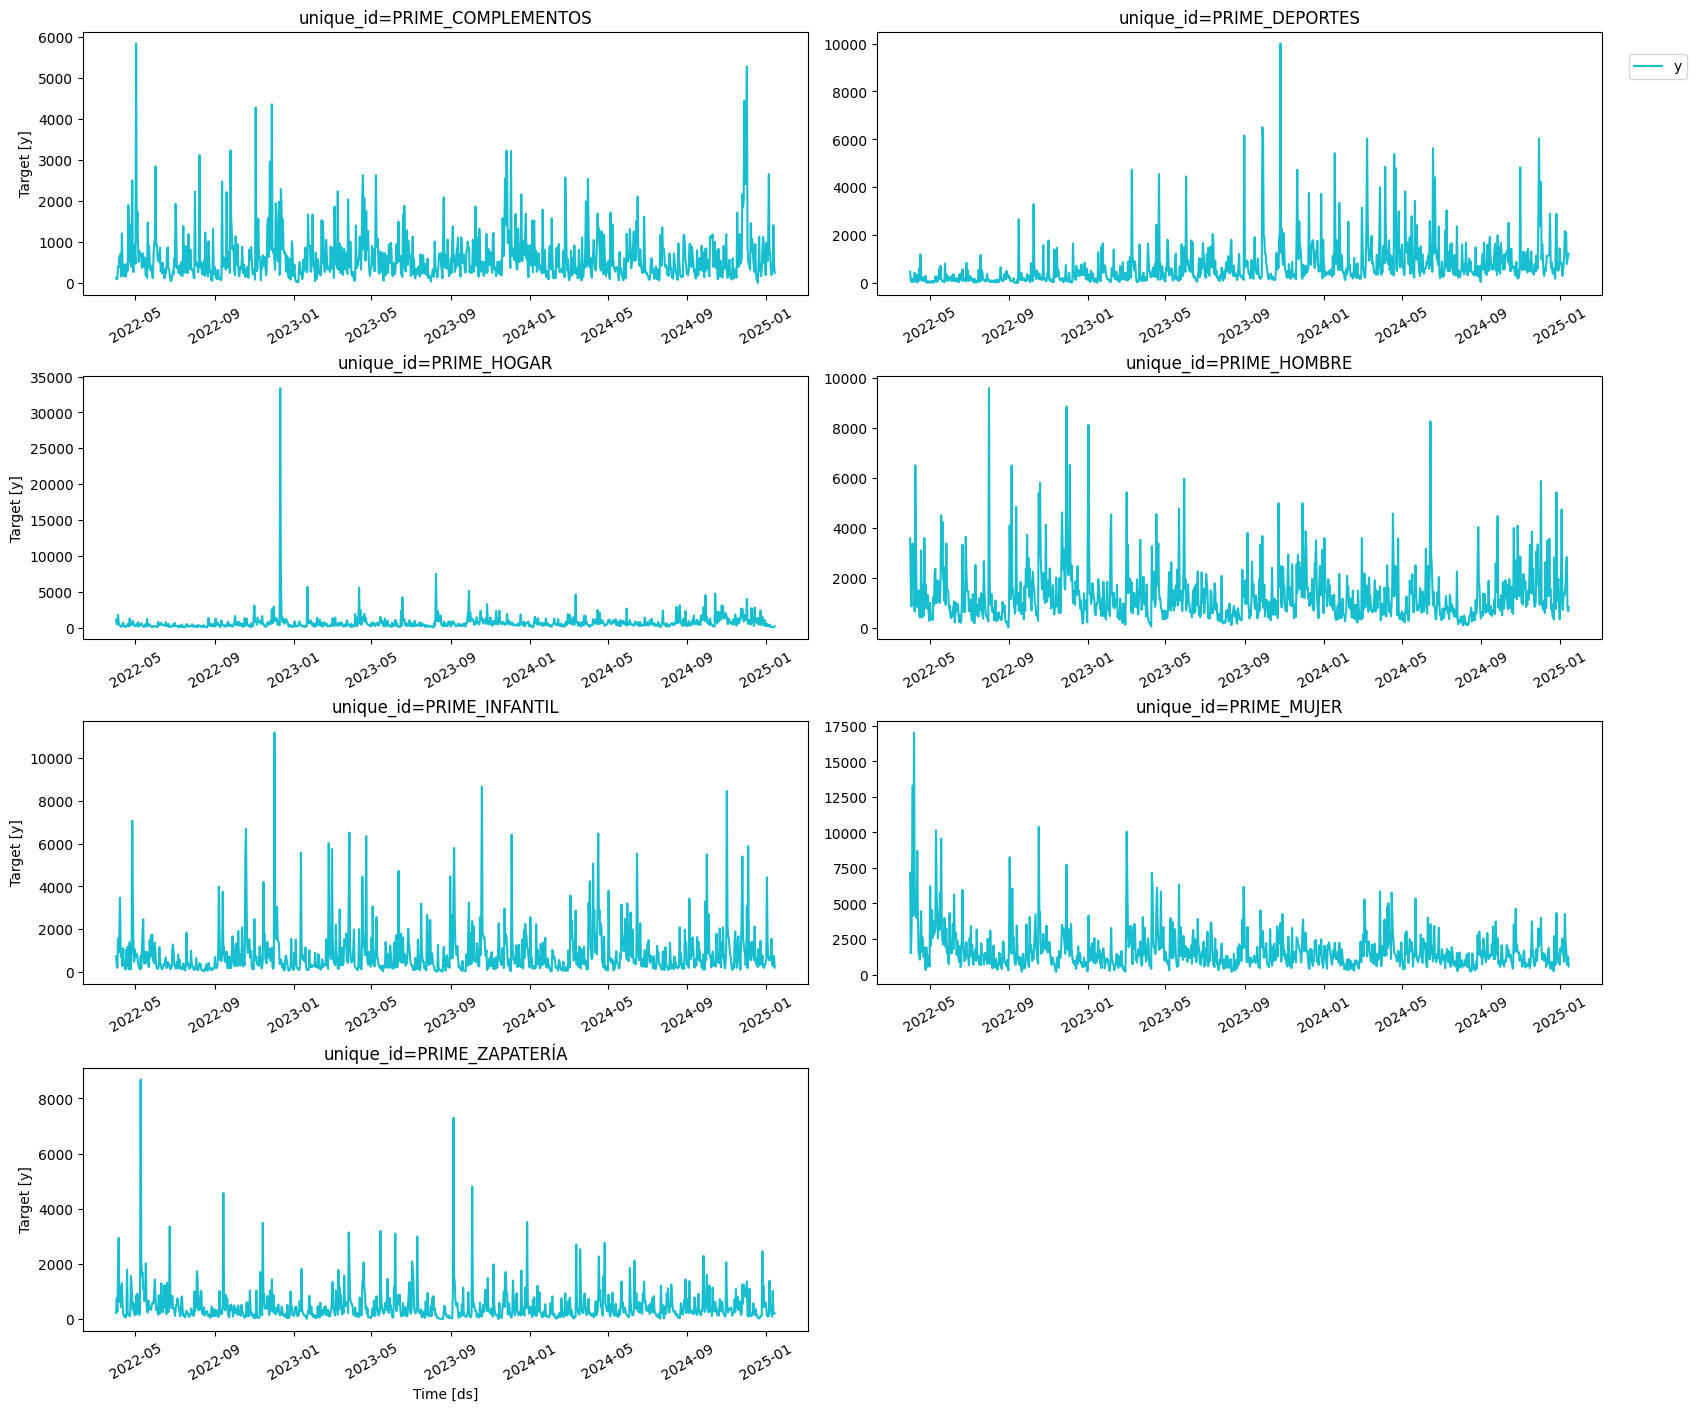

In [3]:
plot_series(df)

In [4]:
horizon = 30 
train_cutoff = df['ds'].max() - pd.Timedelta(days=horizon)  
train_data = df[df['ds'] <= train_cutoff]
test_data = df[df['ds'] > train_cutoff]

In [5]:
train_cutoff

Timestamp('2024-12-15 00:00:00')

In [6]:
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)


In [10]:
from neuralforecast.auto import AutoNHITS, AutoNBEATSx
# Use your own config or AutoNHITS.default_config
config1 = dict(max_steps=10, val_check_steps=1, input_size=horizon*5, 
              mlp_units=3 * [[8, 8]], stat_exog_list=stat_exog_list,futr_exog_list=exogenous_vars,)
model1 = AutoNHITS(h=12, config=config1)

config2 = dict(max_steps=10, val_check_steps=1, input_size=horizon*5,
              mlp_units=3*[[8, 8]], stat_exog_list=stat_exog_list,futr_exog_list=exogenous_vars,)
model2 = AutoNBEATSx(h=12, config=config2)

In [11]:
models = [  model1, model2]      

In [12]:
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=train_data, static_df=static_df)

(pid=17404) Stack (most recent call first): [repeated 5x across cluster]
(pid=17404)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\ffi.py", line 192 in __call__ [repeated 5x across cluster]
(pid=17404)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\executionengine.py", line 40 in check_jit_execution [repeated 4x across cluster]
(pid=17404)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\numba\__init__.py", line 185 in _ensure_llvm [repeated 4x across cluster]
(pid=17404)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\utilsforecast\processing.py", line 21 in <module> [repeated 21x across cluster]
(pid=17404)   File "<frozen importlib._bootstrap>", line 488 in _call_with_frames_removed [repeated 42x across cluster]
(pid=17404)   File "<fr

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s, v_num=0, train_loss_step=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s, v_num=0, train_loss_step=2.84e+3, valid_loss=2.82e+3, train_loss_epoch=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17404) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 14.72it/s, v_num=0, train_loss_step=969.0, valid_loss=563.0, train_loss_epoch=2.84e+3]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s, v_num=0, train_loss_step=742.0, valid_loss=559.0, train_loss_epoch=969.0]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=17404) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s, v_num=0, train_loss_step=725.0, valid_loss=559.0, train_loss_epoch=742.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 1/1 [00:00<00:00

(_train_tune pid=17404) `Trainer.fit` stopped: `max_steps=10` reached.
(pid=8364) r
(pid=8364) o
(pid=8364) Stack (most recent call first): [repeated 8x across cluster]
(pid=8364)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\ffi.py", line 192 in __call__ [repeated 7x across cluster]
(pid=8364)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\executionengine.py", line 40 in check_jit_execution [repeated 7x across cluster]
(pid=8364)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\numba\__init__.py", line 185 in _ensure_llvm [repeated 7x across cluster]
(pid=8364)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\utilsforecast\compat.py", line 36 in <module> [repeated 30x across cluster]
(pid=8364)   File "<frozen importlib._bootstrap>", line

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s, v_num=0, train_loss_step=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s, v_num=0, train_loss_step=2.84e+3, valid_loss=2.82e+3, train_loss_epoch=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
(_train_tune pid=8364) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s, v_num=0, train_loss_step=969.0, valid_loss=563.0, train_loss_epoch=2.84e+3]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s, v_num=0, train_loss_step=742.0, valid_loss=559.0, train_loss_epoch=969.0]  
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 993.68it/s]
(_train_tune pid=8364) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s, v_num=0, train_loss_step=725.0, valid_loss=559.0, train_loss_epoch=742.0]
Validation: |   

(_train_tune pid=8364) `Trainer.fit` stopped: `max_steps=10` reached.
(pid=25200)   File "c:\Users\julian.quintero\WOR
(pid=25200) Stack (most recent call first): [repeated 6x across cluster]
(pid=25200)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\ffi.py", line 192 in __call__ [repeated 6x across cluster]
(pid=25200)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\executionengine.py", line 40 in check_jit_execution [repeated 4x across cluster]
(pid=25200)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\numba\__init__.py", line 185 in _ensure_llvm [repeated 5x across cluster]
(pid=25200)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\utilsforecast\compat.py", line 36 in <module> [repeated 22x across cluster]
(pid=25200)   File "<frozen 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s, v_num=0, train_loss_step=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s, v_num=0, train_loss_step=2.84e+3, valid_loss=2.82e+3, train_loss_epoch=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=25200) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.27it/s]
(_train_tune pid=25200) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s, v_num=0, train_loss_step=969.0, valid_loss=563.0, train_loss_epoch=2.84e+3]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s, v_num=0, train_loss_step=742.0, valid_loss=559.0, train_loss_epoch=969.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=25200) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s, v_num=0, train_loss_step=725.0, valid_loss=559.0, train_loss_epoch

(_train_tune pid=25200) `Trainer.fit` stopped: `max_steps=10` reached.
(pid=15812)   File "c:\Users\julian.quintero\WORKSPACE\
(pid=15812) NEU
(pid=15812) R
(pid=15812) A
(pid=15812) L
(pid=15812) Stack (most recent call first): [repeated 10x across cluster]
(pid=15812)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\ffi.py", line 192 in __call__ [repeated 9x across cluster]
(pid=15812)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\executionengine.py", line 40 in check_jit_execution [repeated 8x across cluster]
(pid=15812)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\numba\__init__.py", line 185 in _ensure_llvm [repeated 9x across cluster]
(pid=15812)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\ray\_private\workers\default_worker.p

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s, v_num=0, train_loss_step=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=15812) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.02it/s]
(_train_tune pid=15812) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s, v_num=0, train_loss_step=2.84e+3, valid_loss=2.82e+3, train_loss_epoch=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s, v_num=0, train_loss_step=969.0, valid_loss=563.0, train_loss_epoch=2.84e+3]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.68it/s]
(_train_tune pid=15812) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s, v_num=0, train_loss_step=742.0, valid_loss=559.0, train_loss_epoch=969.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s, v_num=0, train_loss_step=725.0, valid_loss=559.0, trai

(_train_tune pid=15812) `Trainer.fit` stopped: `max_steps=10` reached.
(pid=17160)   File "c:\Users\juli
(pid=17160) a
(pid=17160) n
(pid=17160) .
(pid=17160) q
(pid=17160) u
(pid=17160) int
(pid=17160) ero\WO
(pid=17160) RK
(pid=17160) CE
(pid=17160) \NEURAL_FORECAST\neuralforecast\
(pid=17160) .v
(pid=17160) e
(pid=17160) n
(pid=17160) v
(pid=17160) \x
(pid=17160) e7
(pid=17160) Lib\site-packag
(pid=17160) es
(pid=17160) n
(pid=17160) u
(pid=17160) A
(pid=17160) Stack (most recent call first): [repeated 7x across cluster]
(pid=17160)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\ffi.py", line 192 in __call__ [repeated 7x across cluster]
(pid=17160)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\executionengine.py", line 40 in check_jit_execution [repeated 8x across cluster]
(pid=17160)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECA

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s, v_num=0, train_loss_step=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17160) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.94it/s]
(_train_tune pid=17160) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s, v_num=0, train_loss_step=2.84e+3, valid_loss=2.82e+3, train_loss_epoch=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s, v_num=0, train_loss_step=969.0, valid_loss=563.0, train_loss_epoch=2.84e+3]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.17it/s]
(_train_tune pid=17160) 
(_train_tune pid=17160) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s, v_num=0, train_loss_step=742.0, valid_loss=559.0, train_loss_epoch=969.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|███████

(_train_tune pid=17160) `Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s, v_num=0, train_loss_step=700.0, valid_loss=559.0, train_loss_epoch=753.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s, v_num=0, train_loss_step=700.0, valid_loss=559.0, train_loss_epoch=700.0]


(pid=31972) e7
(pid=31972) \x
(pid=31972) Stack (most recent call first): [repeated 6x across cluster]
(pid=31972)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\ffi.py", line 192 in __call__ [repeated 5x across cluster]
(pid=31972)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\executionengine.py", line 40 in check_jit_execution [repeated 6x across cluster]
(pid=17160)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\numba\__init__.py", line 185 in _ensure_llvm [repeated 5x across cluster]
(pid=17160)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\ray\_private\workers\default_worker.py", line 289 in <module> [repeated 22x across cluster]
(pid=17160)   File "<frozen importlib._bootstrap>", line 488 in _call_with_frames_removed [repeated 4

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, v_num=0, train_loss_step=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=31972) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.99it/s]
(_train_tune pid=31972) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s, v_num=0, train_loss_step=2.84e+3, valid_loss=2.82e+3, train_loss_epoch=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 421.50it/s]
(_train_tune pid=31972) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s, v_num=0, train_loss_step=969.0, valid_loss=563.0, train_loss_epoch=2.84e+3]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  9.86it/s, v_num=0, train_loss_step=742.0, valid_loss=559.0, train_loss_epoch=969.0]  
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.05it/s]
(_train_tune pid=31972) 
Epoch 4: 100

(_train_tune pid=31972) `Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s, v_num=0, train_loss_step=700.0, valid_loss=559.0, train_loss_epoch=753.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s, v_num=0, train_loss_step=700.0, valid_loss=559.0, train_loss_epoch=700.0]


(pid=6600)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralf
(pid=6600) Stack (most recent call first): [repeated 8x across cluster]
(pid=6600)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\ffi.py", line 192 in __call__ [repeated 8x across cluster]
(pid=6600)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\executionengine.py", line 40 in check_jit_execution [repeated 6x across cluster]
(pid=31972)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\numba\__init__.py", line 185 in _ensure_llvm [repeated 7x across cluster]
(pid=31972)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\ray\_private\workers\default_worker.py", line 289 in <module> [repeated 30x across cluster]
(pid=31972)   File "<frozen importlib._bootstrap>", line

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.09it/s, v_num=0, train_loss_step=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.02it/s]
(_train_tune pid=6600) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s, v_num=0, train_loss_step=2.84e+3, valid_loss=2.82e+3, train_loss_epoch=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  9.75it/s, v_num=0, train_loss_step=969.0, valid_loss=563.0, train_loss_epoch=2.84e+3]  
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=6600) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.06it/s]
(_train_tune pid=6600) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s, v_num=0, train_loss_step=742.0, valid_loss=559.0, train_loss_epoch=969.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s, v_num=0, train_loss_step=725.0, valid_loss=559.0, train_los

(_train_tune pid=6600) `Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s, v_num=0, train_loss_step=700.0, valid_loss=559.0, train_loss_epoch=753.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s, v_num=0, train_loss_step=700.0, valid_loss=559.0, train_loss_epoch=700.0]


(pid=8844)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_F
(pid=8844) O
(pid=8844) R
(pid=8844) Stack (most recent call first): [repeated 8x across cluster]
(pid=8844)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\ffi.py", line 192 in __call__ [repeated 5x across cluster]
(pid=8844)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\executionengine.py", line 40 in check_jit_execution [repeated 7x across cluster]
(pid=8844)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\numba\__init__.py", line 185 in _ensure_llvm [repeated 6x across cluster]
(pid=8844)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\ray\_private\workers\default_worker.py", line 289 in <module> [repeated 29x across cluster]
(pid=8844)   File "<frozen importlib._bootstrap

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s, v_num=0, train_loss_step=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  9.95it/s, v_num=0, train_loss_step=2.84e+3, valid_loss=2.82e+3, train_loss_epoch=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.24it/s]
                                                                      
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s, v_num=0, train_loss_step=969.0, valid_loss=563.0, train_loss_epoch=2.84e+3]  
(_train_tune pid=8844) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
(_train_tune pid=8844) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s, v_num=0, train_loss_step=742.0, valid_loss=559.0, train_loss_epoch=969.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s, v_num=0, train_loss_st

(_train_tune pid=8844) `Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s, v_num=0, train_loss_step=700.0, valid_loss=559.0, train_loss_epoch=753.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s, v_num=0, train_loss_step=700.0, valid_loss=559.0, train_loss_epoch=700.0]


(pid=24188)   File "c:\Users\julian.quintero\W
(pid=24188) K
(pid=24188) S
(pid=24188) C
(pid=24188) U
(pid=24188) L
(pid=24188) _
(pid=24188) F
(pid=24188) O [repeated 2x across cluster]
(pid=24188) R [repeated 3x across cluster]
(pid=24188) Stack (most recent call first): [repeated 7x across cluster]
(pid=24188)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\ffi.py", line 192 in __call__ [repeated 6x across cluster]
(pid=24188)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\executionengine.py", line 40 in check_jit_execution [repeated 5x across cluster]
(pid=24188)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\numba\__init__.py", line 185 in _ensure_llvm [repeated 5x across cluster]
(pid=24188)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-p

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s, v_num=0, train_loss_step=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s, v_num=0, train_loss_step=2.84e+3, valid_loss=2.82e+3, train_loss_epoch=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=24188) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]
(_train_tune pid=24188) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s, v_num=0, train_loss_step=969.0, valid_loss=563.0, train_loss_epoch=2.84e+3]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s, v_num=0, train_loss_step=742.0, valid_loss=559.0, train_loss_epoch=969.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.39it/s]
(_train_tune pid=24188) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.16i

(_train_tune pid=24188) `Trainer.fit` stopped: `max_steps=10` reached.
(pid=14400)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neural
(pid=14400) Stack (most recent call first): [repeated 9x across cluster]
(pid=14400)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\ffi.py", line 192 in __call__ [repeated 8x across cluster]
(pid=14400)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\llvmlite\binding\executionengine.py", line 40 in check_jit_execution [repeated 8x across cluster]
(pid=14400)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\numba\__init__.py", line 185 in _ensure_llvm [repeated 7x across cluster]
(pid=14400)   File "c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\xe7\Lib\site-packages\utilsforecast\compat.py", line 36 in <module> [repeated 38x across cluster

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s, v_num=0, train_loss_step=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=14400) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
(_train_tune pid=14400) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s, v_num=0, train_loss_step=2.84e+3, valid_loss=2.82e+3, train_loss_epoch=7.69e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s, v_num=0, train_loss_step=969.0, valid_loss=563.0, train_loss_epoch=2.84e+3]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s, v_num=0, train_loss_step=742.0, valid_loss=559.0, train_loss_epoch=969.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.56it/s]
(_train_tune pid=14400) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s, v_num=0, train_loss_step=725.0, valid_loss=559.0, train_loss_epoch

(_train_tune pid=14400) `Trainer.fit` stopped: `max_steps=10` reached.
2025-01-17 20:20:14,178	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/julian.quintero/ray_results/_train_tune_2025-01-17_20-15-54' in 0.1495s.
Seed set to 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s, v_num=0, train_loss_step=700.0, valid_loss=559.0, train_loss_epoch=753.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s, v_num=0, train_loss_step=700.0, valid_loss=559.0, train_loss_epoch=700.0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [13]:
Y_hat_df = nf.predict(futr_df=test_data)
Y_hat_df = pd.merge(Y_hat_df, test_data[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\neuralforecast\core.py:904: UserWarning: Dropped 126 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

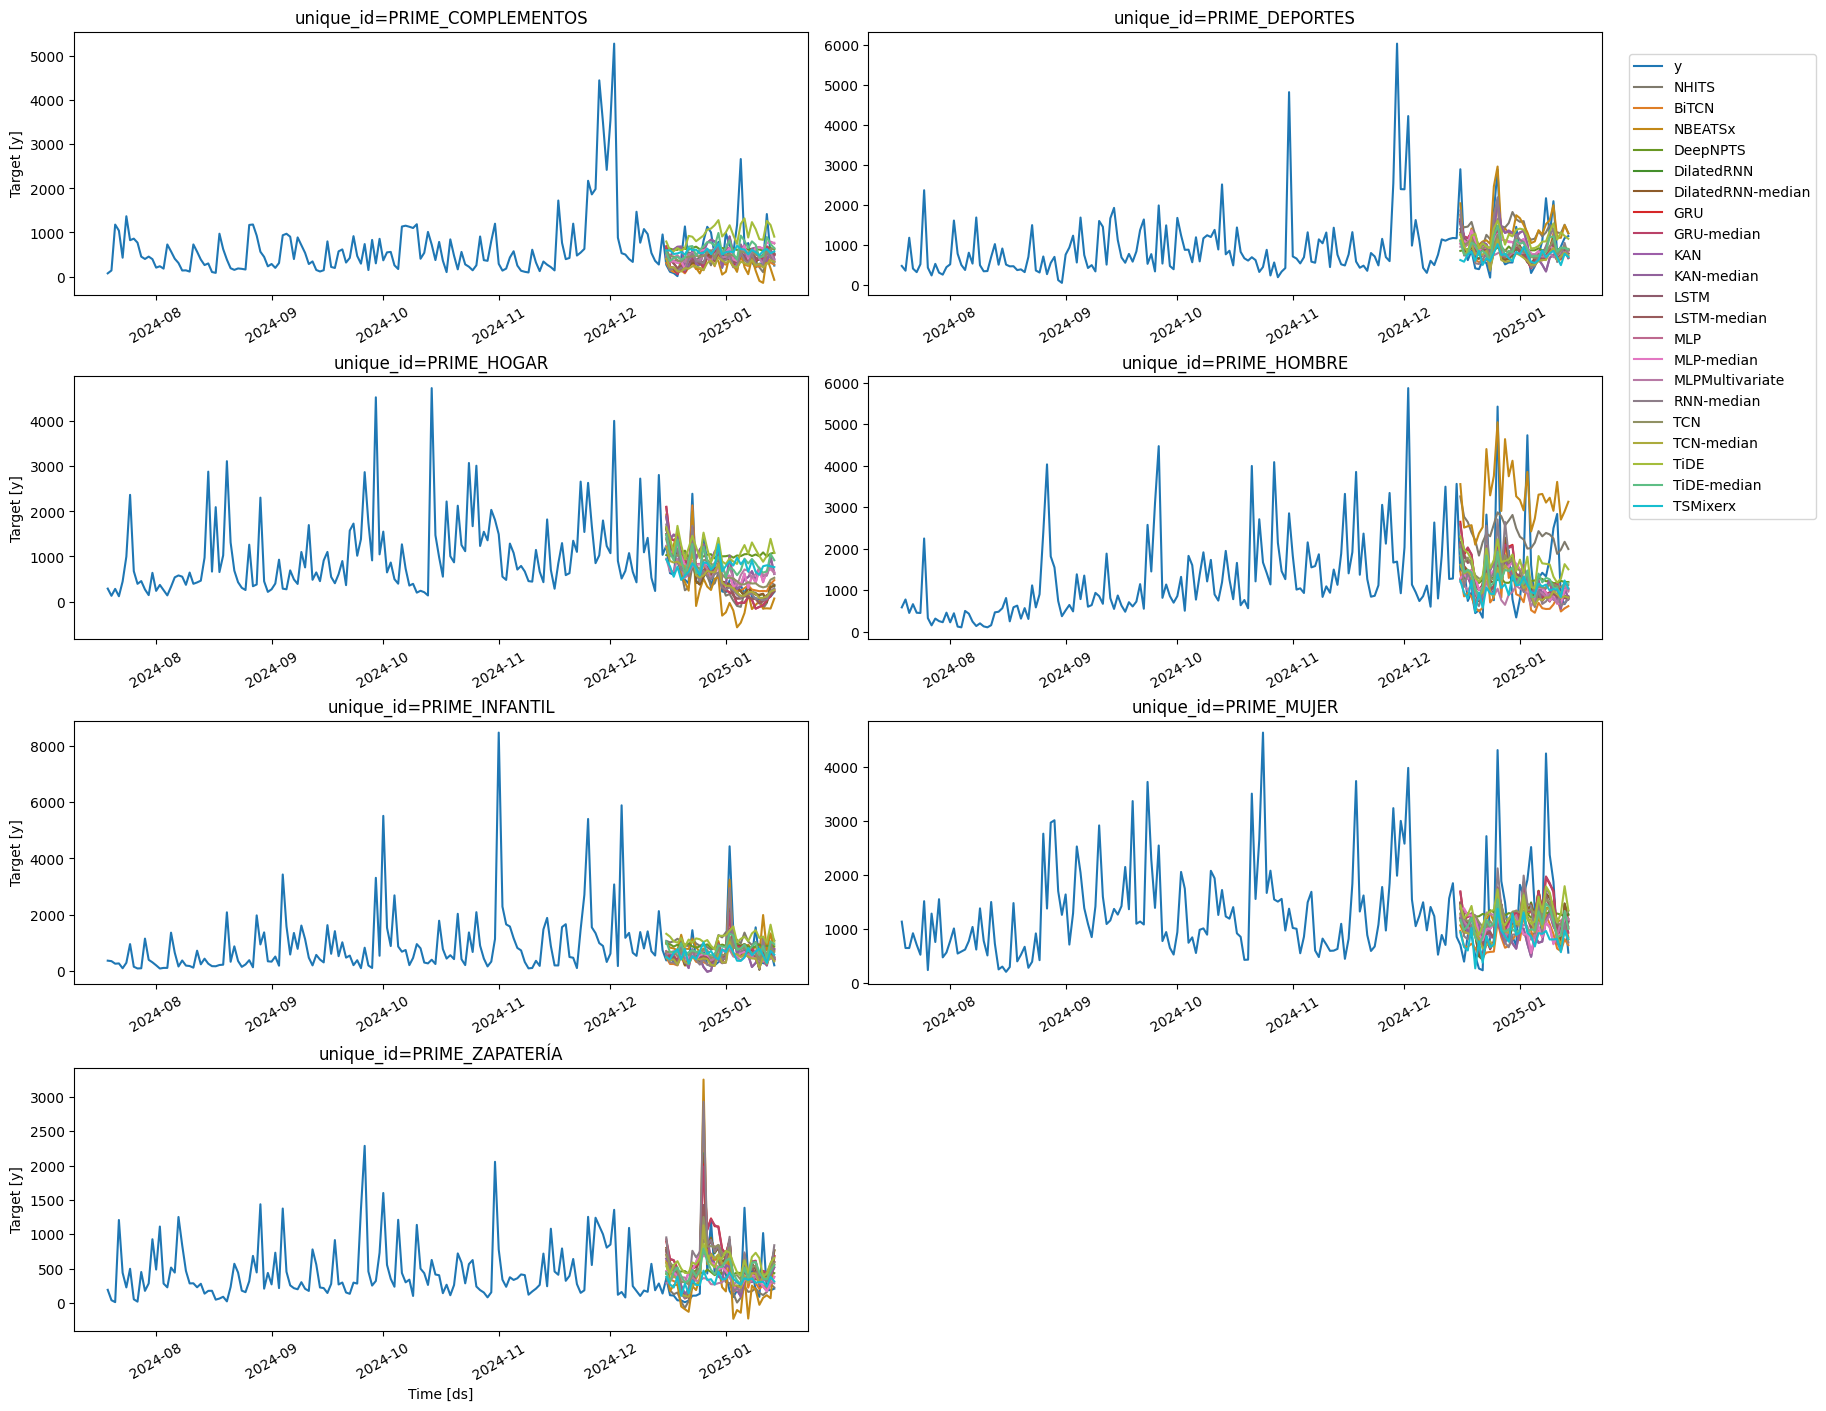

In [79]:
plot_series(train_data, Y_hat_df, max_insample_length=horizon*5)


In [14]:
df_ols = pd.read_csv('01_FORE_PRIME.csv')
df_ols

df_ols['ds'] = pd.to_datetime(df_ols['ds'])

# Realizar el merge
Y_hat_df2 = pd.merge(Y_hat_df, df_ols, on=['unique_id', 'ds'], how='left')
Y_hat_df2

,unique_id,ds,AutoNHITS,AutoNBEATSx,y,OLS
0,PRIME_COMPLEMENTOS,2024-12-16,1172.293945,954.343567,265,306.541882
1,PRIME_COMPLEMENTOS,2024-12-17,2111.231934,954.170654,107,118.702924
2,PRIME_COMPLEMENTOS,2024-12-18,2073.645508,953.914429,78,93.056840
3,PRIME_COMPLEMENTOS,2024-12-19,5011.958496,952.493713,9,83.397195
4,PRIME_COMPLEMENTOS,2024-12-20,3660.224121,953.664917,411,339.000065
...,...,...,...,...,...,...
79,PRIME_ZAPATERÍA,2024-12-23,2145.894775,136.088287,105,585.907190
80,PRIME_ZAPATERÍA,2024-12-24,734.857910,135.589249,107,356.269411
81,PRIME_ZAPATERÍA,2024-12-25,2312.877930,136.840454,134,409.232263
82,PRIME_ZAPATERÍA,2024-12-26,464.129333,136.187866,2454,4919.033880


In [15]:
import pandas as pd

# Supongamos que df es tu DataFrame
def calculate_metrics(df):
    # Identificar columnas de predicción
    prediction_cols = [col for col in df.columns if col not in ['unique_id', 'ds', 'y']]
    
    results = []

    # Agrupar por unique_id
    for unique_id, group in df.groupby('unique_id'):
        y_real = group['y'].values
        y_sum = abs(y_real).sum()

        # Calcular métricas para cada columna de predicción
        for col in prediction_cols:
            y_pred = group[col].values
            abs_error = abs(y_real - y_pred)
            
            wape = abs_error.sum() / y_sum if y_sum != 0 else None
            std_dev = abs_error.std()

            results.append({
                'unique_id': unique_id,
                'model': col,
                'WAPE': wape,
                'StdDev_Error': std_dev
            })
    
    # Convertir resultados a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Aplicar la función al DataFrame
metrics_df = calculate_metrics(Y_hat_df2)


print(metrics_df.to_string())

             unique_id        model      WAPE  StdDev_Error
0   PRIME_COMPLEMENTOS    AutoNHITS  6.441746   2174.010707
1   PRIME_COMPLEMENTOS  AutoNBEATSx  1.343464    268.876636
2   PRIME_COMPLEMENTOS          OLS  0.521621    323.866975
3       PRIME_DEPORTES    AutoNHITS  1.757362    850.105454
4       PRIME_DEPORTES  AutoNBEATSx  0.726997    462.731678
5       PRIME_DEPORTES          OLS  0.280320    227.704741
6          PRIME_HOGAR    AutoNHITS  4.449666   3668.459606
7          PRIME_HOGAR  AutoNBEATSx  0.581327    288.185290
8          PRIME_HOGAR          OLS  0.230208    190.779064
9         PRIME_HOMBRE    AutoNHITS  2.930854   1666.306936
10        PRIME_HOMBRE  AutoNBEATSx  1.694608    661.671427
11        PRIME_HOMBRE          OLS  0.390126    668.623875
12      PRIME_INFANTIL    AutoNHITS  1.701115    866.991592
13      PRIME_INFANTIL  AutoNBEATSx  0.707685    175.865417
14      PRIME_INFANTIL          OLS  0.381699    177.019818
15         PRIME_MUJER    AutoNHITS  1.6

In [16]:
# Ordenar por unique_id y WAPE
metrics_df_sorted = metrics_df.sort_values(by=['unique_id', 'WAPE'])

# Obtener el modelo con menor WAPE para cada unique_id
best_models_df = metrics_df_sorted.groupby('unique_id').first().reset_index()

best_models_df

,unique_id,model,WAPE,StdDev_Error
0,PRIME_COMPLEMENTOS,OLS,0.521621,323.866975
1,PRIME_DEPORTES,OLS,0.280320,227.704741
2,PRIME_HOGAR,OLS,0.230208,190.779064
3,PRIME_HOMBRE,OLS,0.390126,668.623875
4,PRIME_INFANTIL,OLS,0.381699,177.019818
5,PRIME_MUJER,OLS,0.510688,632.646961
6,PRIME_ZAPATERÍA,AutoNBEATSx,0.859629,619.615384
